In [ ]:
!pip install gpjax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.3/466.3 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 370.9/370.9 kB 26.5 MB/s eta 0:00:00
  Attempting uninstall: flax
    Found existing installation: flax 0.10.7
    Uninstalling flax-0.10.7:
      Successfully uninstalled flax-0.10.7


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import jax
import jax.numpy as jnp
import jax.random as jr
import gpjax as gpx
import optax
from gpjax.parameters import NonNegativeReal
from sklearn.cluster import KMeans

# Enable float64 mode
jax.config.update("jax_enable_x64", True)

# [Lorenz generation code - unchanged]
def lorenz(t, state, sigma=10., rho=28., beta=8/3):
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return [dx, dy, dz]

t_span = (0, 50)
t_eval = np.linspace(0, 50, 10000)
y0_1 = [0., 1., 1.05]
y0_2 = [0., -1., 1.05]
sol1 = solve_ivp(lorenz, t_span, y0_1, t_eval=t_eval)
sol2 = solve_ivp(lorenz, t_span, y0_2, t_eval=t_eval)
data = np.concatenate([sol1.y.T, sol2.y.T], axis=0)

states = data[:-1]
targets = data[1:] - data[:-1]

# Normalize targets
targets_mean = targets.mean(axis=0)
targets_std = targets.std(axis=0)
targets_normalized = (targets - targets_mean) / targets_std

states_jax = jnp.array(states, dtype=jnp.float64)
targets_jax = jnp.array(targets_normalized, dtype=jnp.float64)

# >=5% inducing points for 20k observations
key = jr.PRNGKey(0)
kmeans = KMeans(n_clusters=1000, random_state=0).fit(states)
inducing_inputs = jnp.array(kmeans.cluster_centers_, dtype=jnp.float64)

# Use CollapsedVariationalGaussian (<50k observations)
kernel = gpx.kernels.RBF()
mean_function = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=mean_function, kernel=kernel)

likelihood = gpx.likelihoods.Gaussian(
    num_datapoints=states_jax.shape[0],
    obs_stddev=NonNegativeReal(jnp.array(0.1))
)
posterior = prior * likelihood

# jitter for numerical stability
q = gpx.variational_families.CollapsedVariationalGaussian(
    posterior=posterior,
    inducing_inputs=inducing_inputs,
    jitter=1e-4
)

D = gpx.Dataset(X=states_jax, y=targets_jax)

# Fit model
trained_q, history = gpx.fit(
    model=q,
    objective=gpx.objectives.collapsed_elbo,
    train_data=D,
    optim=optax.adam(learning_rate=1e-4),
    num_iters=3000,
    key=key,
    verbose=True,
    log_rate=100
)

# Prediction
xtest = jnp.array([[0.0, 1.0, 1.0]], dtype=jnp.float64)
predictive_dist = trained_q(xtest, D)
pred_mean = predictive_dist.mean * targets_std + targets_mean

  0%|          | 0/3000 [00:00<?, ?it/s]

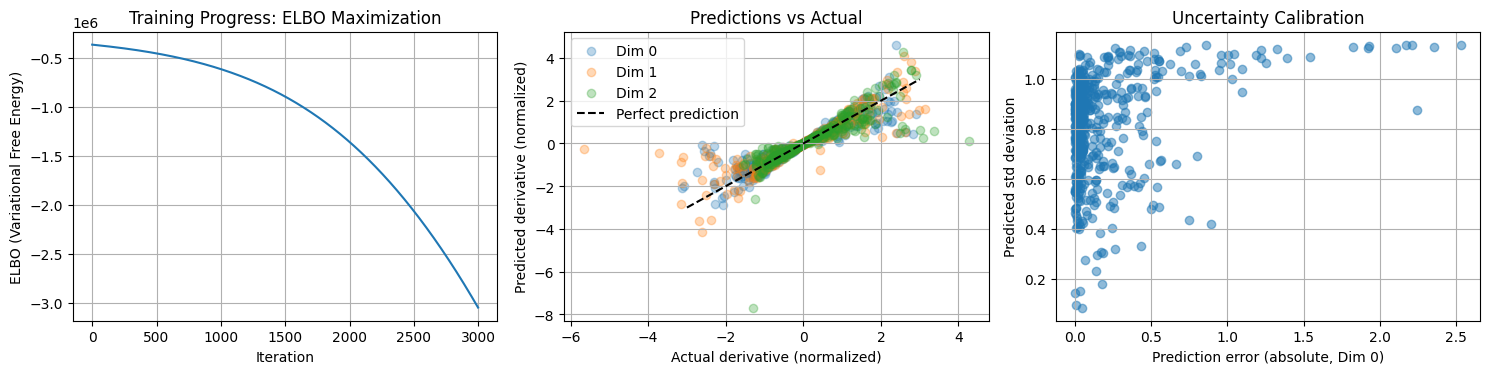

Performance Metrics:
MSE per dimension: [0.17424776 0.24222369 0.24576382]
MAE per dimension: [0.20448499 0.20059262 0.18738828]
R² per dimension: [0.8296646  0.76393574 0.6875708 ]

Final ELBO: -3050804.9336
ELBO improvement: -2685099.2594

Learned Kernel Parameters:
Lengthscale: 0.7546350026527904
Variance: 1.294893417112494
Observation noise: 0.06796463373850016


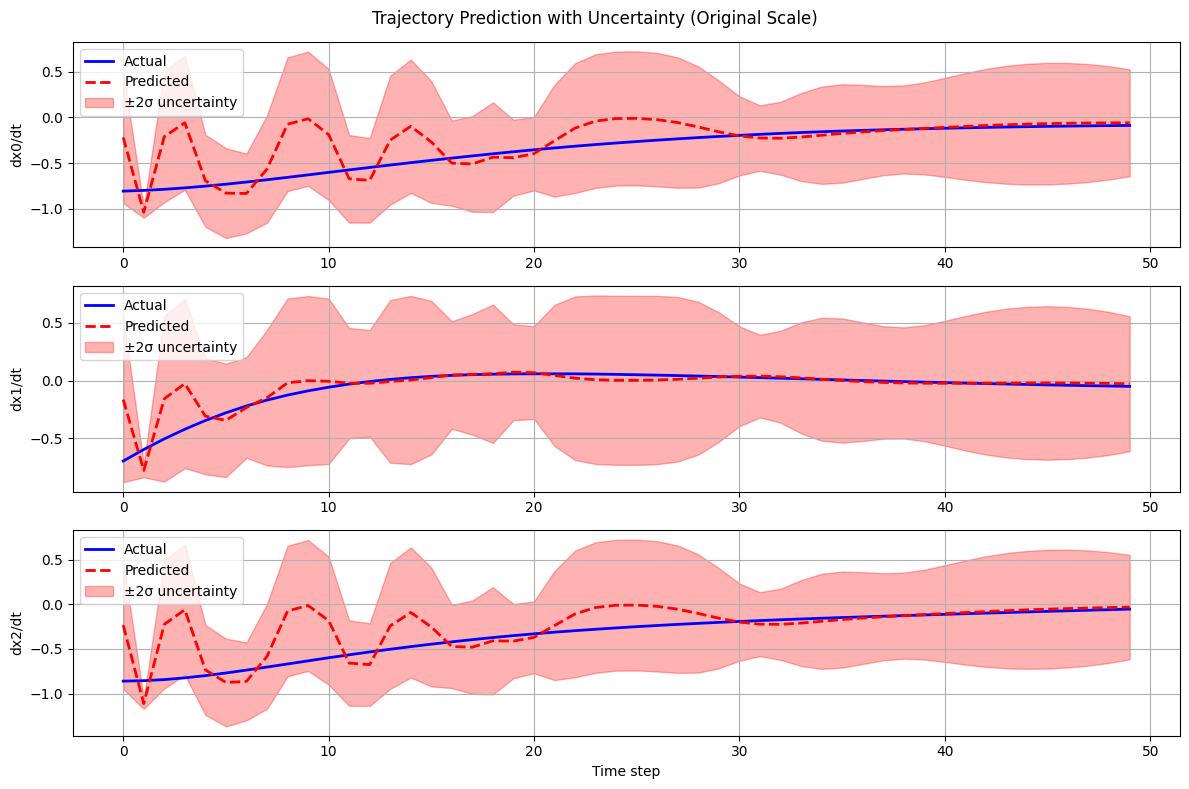

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Plot training history (ELBO / variational free energy)
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(history)
plt.xlabel('Iteration')
plt.ylabel('ELBO (Variational Free Energy)')
plt.title('Training Progress: ELBO Maximization')
plt.grid(True)

# 2. Predictions vs Actual on training data
n_viz = 500
viz_indices = np.random.choice(len(states_jax), n_viz, replace=False)
X_viz = states_jax[viz_indices]
y_viz = targets_jax[viz_indices]

# Get predictions (in normalized space)
pred_dist = trained_q(X_viz, D)
pred_mean = pred_dist.mean
pred_std = jnp.sqrt(jnp.diag(pred_dist.covariance()))

# Plot predictions vs actual for each dimension (both in normalized space)
plt.subplot(1, 3, 2)
for dim in range(3):
    plt.scatter(y_viz[:, dim], pred_mean[:, dim], alpha=0.3, label=f'Dim {dim}')
plt.plot([-3, 3], [-3, 3], 'k--', label='Perfect prediction')
plt.xlabel('Actual derivative (normalized)')
plt.ylabel('Predicted derivative (normalized)')
plt.title('Predictions vs Actual')
plt.legend()
plt.grid(True)

# 3. Prediction uncertainty
plt.subplot(1, 3, 3)
errors_dim0 = np.abs(y_viz[:, 0] - pred_mean[:, 0])
plt.scatter(errors_dim0, pred_std, alpha=0.5)
plt.xlabel('Prediction error (absolute, Dim 0)')
plt.ylabel('Predicted std deviation')
plt.title('Uncertainty Calibration')
plt.grid(True)

plt.tight_layout()
plt.savefig('lorenz_gp_performance.png', dpi=150)
plt.show()

# 4. Detailed metrics (computed in normalized space)
mse = jnp.mean((y_viz - pred_mean)**2, axis=0)
mae = jnp.mean(jnp.abs(y_viz - pred_mean), axis=0)
r2 = 1 - jnp.sum((y_viz - pred_mean)**2, axis=0) / jnp.sum((y_viz - jnp.mean(y_viz, axis=0))**2, axis=0)

print("Performance Metrics:")
print(f"MSE per dimension: {mse}")
print(f"MAE per dimension: {mae}")
print(f"R² per dimension: {r2}")
print(f"
Final ELBO: {history[-1]:.4f}")
print(f"ELBO improvement: {history[-1] - history[0]:.4f}")

# 5. Visualize learned kernel parameters
print("
Learned Kernel Parameters:")
print(f"Lengthscale: {trained_q.posterior.prior.kernel.lengthscale.value}")
print(f"Variance: {trained_q.posterior.prior.kernel.variance.value}")
print(f"Observation noise: {trained_q.posterior.likelihood.obs_stddev.value}")

# 6. Trajectory prediction visualization
test_traj_idx = 100
traj_length = 50
test_states = states_jax[test_traj_idx:test_traj_idx+traj_length]
test_targets = targets_jax[test_traj_idx:test_traj_idx+traj_length]

traj_pred_dist = trained_q(test_states, D)
traj_pred_mean = traj_pred_dist.mean
traj_pred_std = jnp.sqrt(jnp.diag(traj_pred_dist.covariance()))

# FIXED: Denormalize for visualization in original space
test_targets_denorm = test_targets * targets_std + targets_mean
traj_pred_mean_denorm = traj_pred_mean * targets_std + targets_mean
# For std, we need to scale by the std of each dimension separately
# Since traj_pred_std is 1D (marginal std for all points), we approximate by using mean std
traj_pred_std_denorm = traj_pred_std * jnp.mean(targets_std)

fig, axes = plt.subplots(3, 1, figsize=(12, 8))
for dim in range(3):
    axes[dim].plot(test_targets_denorm[:, dim], 'b-', label='Actual', linewidth=2)
    axes[dim].plot(traj_pred_mean_denorm[:, dim], 'r--', label='Predicted', linewidth=2)
    # Use the same uncertainty band for all dimensions (approximation)
    axes[dim].fill_between(
        range(traj_length),
        traj_pred_mean_denorm[:, dim] - 2*traj_pred_std_denorm,
        traj_pred_mean_denorm[:, dim] + 2*traj_pred_std_denorm,
        alpha=0.3, color='red', label='±2σ uncertainty'
    )
    axes[dim].set_ylabel(f'dx{dim}/dt')
    axes[dim].legend()
    axes[dim].grid(True)
axes[2].set_xlabel('Time step')
plt.suptitle('Trajectory Prediction with Uncertainty (Original Scale)')
plt.tight_layout()
plt.savefig('lorenz_trajectory_prediction.png', dpi=150)
plt.show()